<a href="https://colab.research.google.com/github/FunNyLuAz/Performance-em-Sistemas-Ciberfisicos/blob/main/Atividade%20Pr%C3%A1tica%20em%20Grupo%20RA3-3-2023-1/Atividade%20Pr%C3%A1tica%20em%20Grupo%20RA3-3-2023-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Problema proposto para comparação de técnicas de sincronização:

Consideramos um sistema paralelo em Python, onde vários threads estão realizando cálculos independentes que contribuem para um resultado final. Especificamente, cada thread é responsável por realizar um conjunto de cálculos complexos cujo resultado precisa ser somado para se obter uma resposta final. O Método de Monte Carlo para Cálculo de Área sob a curva é ideal para esta análise.

No entanto, é imperativo que todas as threads concluam seus cálculos individuais antes de prosseguir para a etapa de soma. O desafio é garantir que nenhuma thread inicie o processo de soma até que todas as threads tenham concluído seus cálculos individuais.

Este cenário será usado como base para a comparação prática de diferentes técnicas de sincronização em Python: Locks, Semaphores, Conditions e Barriers. Cada técnica será implementada e avaliada com base no tempo necessário para o cálculo da área.

**Você terá que pesquisar o que são Barriers e como usá-las em Python e fazer quatro análises distintas:** 
1. **Locks**: Uma maneira de resolver isso é ter um Lock que protege o acesso ao resultado final. Cada thread adquire o lock, atualiza o resultado final e libera o lock. No entanto, as threads precisam esperar que outras threads concluam sem um mecanismo explícito.

2. **Semaphores**: Um semáforo pode ser usado para contar o número de threads que concluíram seu trabalho. Quando uma thread termina, ela decrementa o semáforo. Quando o semáforo atinge zero, o resultado final pode ser calculado.

3. **Conditions**: Uma variável de condição pode ser usada para fazer todas as threads esperarem até que todas as outras threads tenham terminado seu trabalho.

4. **Barriers**: Um Barrier pode ser usado para fazer com que todas as threads esperem até que todas tenham terminado seus cálculos. Uma vez que todas as threads atingem o Barrier, elas podem continuar a calcular o resultado final.

Este trabalho deve ser realizado em Python, no Google Colaboratory, em grupo e o link para o caderno onde seu código pode ser executado deve ser postado no Ambiente Virtual de Aprendizagem (Canvas) no local apropriado. 



# Pesquisa sobre Barriers

É uma forma de sincronizar as threads, onde a sequência do código só ocorre quando todas elas chegarem ao ponto indicado. Uma analogia seria quando crianças atravessam a rua com um responsável apenas quando todas elas chegarem ao ponto.

# Código das análises

## Código base

In [1]:
import matplotlib.pyplot as pyplot
import numpy as np
import sympy as sp

from threading import Thread
from time import time_ns, sleep
from random import random

In [2]:
min_x = 0  # Initial value for x axis
max_x = 2  # End value for x axis

num_threads = 200  # Amount of threads
vals_per_threads = 100  # Amount of values for each thread

In [3]:
def plot_graph_monte_carlo(f, x, points, min_x, max_x):
    x_vals = [i for i in np.linspace(min_x, max_x, 500)]
    y_vals = [f.subs(x, i) for i in x_vals]

    min_y = min(y_vals)  # Gets the bottom of the function
    max_y = max(y_vals)  # Gets the top of the function

    # Scales the points for the boundries of the function
    for i in range(len(points)):
        points[i] = (
            points[i][0] * (max_x - min_x) + min_x,
            points[i][1] * (max_y - min_y) + min_y
        )
    
    pos_under_points = ([], [])
    neg_under_points = ([], [])
    above_points = ([], [])

    # Calculates for each point if it is above or under the curve
    for point in points:
        y_curve = f.subs(x, point[0])
        if (y_curve >= point[1] and point[1] >= 0):
            pos_under_points[0].append(point[0])
            pos_under_points[1].append(point[1])
        elif (y_curve < point[1] and point[1] < 0):
            neg_under_points[0].append(point[0])
            neg_under_points[1].append(point[1])
        else:
            above_points[0].append(point[0])
            above_points[1].append(point[1])
    
    # Prints results
    area = (max_x - min_x) * (max_y - min_y)  # Area of the graph
    pos_ratio = len(pos_under_points[0]) / len(points)  # Ratio of under curve points with positive y
    neg_ratio = len(neg_under_points[0]) / len(points)  # Ratio of under curve points with negative y
    print(f"Exact integral: {sp.integrate(f, (x, min_x, max_x)).evalf()}")
    print(f"Aproximation integral using Monte Carlo method: {area * (pos_ratio - neg_ratio)}")
    print()

    # Plots the graph
    pyplot.title(r"Integral with Monte Carlo")
    pyplot.xlabel(r"x")
    pyplot.ylabel(r"y")
    pyplot.axhline(y=0, color="black", linestyle="--")
    pyplot.axvline(x=0, color="black", linestyle="--")
    pyplot.scatter(*above_points, color="orange")  # Above curve
    pyplot.scatter(*neg_under_points, color="blue")  # Negative under curve
    pyplot.scatter(*pos_under_points, color="green")  # Positive under curve
    pyplot.plot(x_vals, y_vals, color="red", label="Function")
    pyplot.legend()
    pyplot.show()

In [4]:
def run(threads, points):
  delta_time = time_ns()

  # Initialize the threads
  for thread in threads:
      thread.start()

  # Awaits end of each threads
  for thread in threads:
      thread.join()

  # Plots the graph appling the points
  x = sp.Symbol('x')
  f = sp.sin(10*x) + 0.5  # Função escolhida
  plot_graph_monte_carlo(f, x, points, min_x, max_x)

  delta_time = time_ns() - delta_time
  print(f"\n{delta_time/1_000_000_000}s ({delta_time}ns)")

## Locks

In [5]:
from threading import Lock

In [6]:
def thread_lock(vals, lock):
    thread_points = []  # Random points list generated by this thread
    for _ in range(vals):
        thread_points.append((random(), random()))
    
    lock.acquire()
    global points
    points.extend(thread_points)
    lock.release()

Exact integral: 1.05919179381866
Aproximation integral using Monte Carlo method: 1.04219460129358



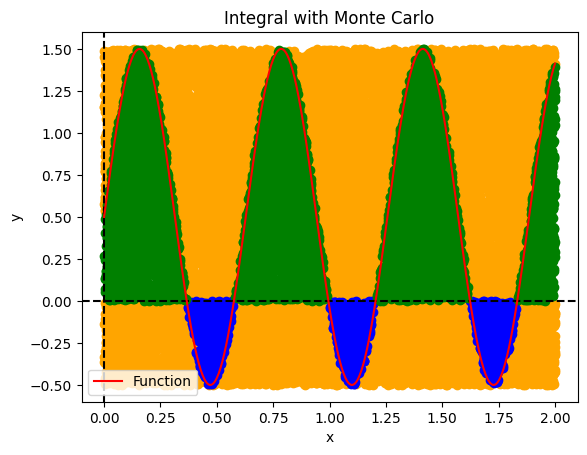


24.669559907s (24669559907ns)


In [7]:
threads = []  # Threads list
points = []  # Random points list generated

# Creates the lock for the threads
lock = Lock()

# Creates the threads
for i in range(num_threads):
    threads.append(Thread(target=thread_lock, args=(vals_per_threads, lock)))

# Runs the program
run(threads, points)

## Semaphores

In [8]:
from threading import Semaphore

In [9]:
def thread_semaphore(vals, semaphore):
    thread_points = []  # Random points list generated by this thread
    for _ in range(vals):
        thread_points.append((random(), random()))
    
    semaphore.acquire()
    global points
    points.extend(thread_points)
    semaphore.release()

Exact integral: 1.05919179381866
Aproximation integral using Monte Carlo method: 1.04339459507746



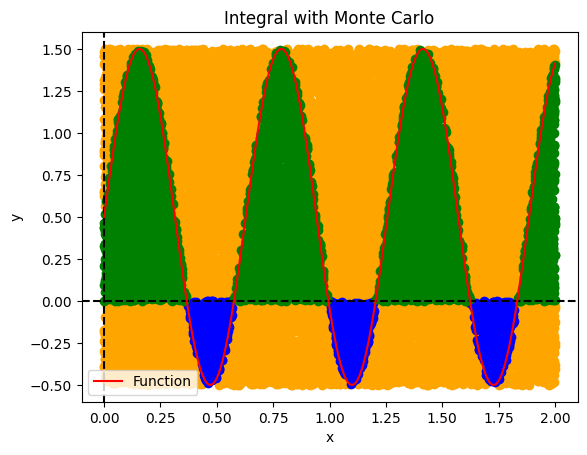


17.097598427s (17097598427ns)


In [10]:
threads = []  # Threads list
points = []  # Random points list generated

# Creates the semaphore for the threads
semaphore = Semaphore()

# Creates the threads
for i in range(num_threads):
    threads.append(Thread(target=thread_semaphore, args=(vals_per_threads, semaphore)))

# Runs the program
run(threads, points)

## Conditions

In [11]:
from threading import Condition

In [12]:
def thread_condition(vals, condition):
    thread_points = []  # Random points list generated by this thread
    for _ in range(vals):
        thread_points.append((random(), random()))
    
    with condition:
      global points
      points.extend(thread_points)
      condition.notify(n=1)

Exact integral: 1.05919179381866
Aproximation integral using Monte Carlo method: 1.04559458368122



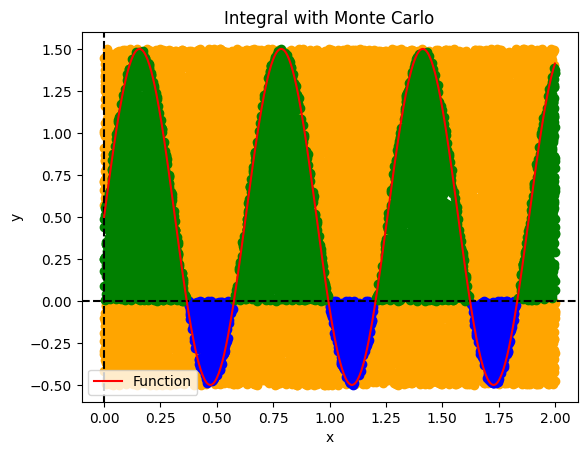


19.155000113s (19155000113ns)


In [13]:
threads = []  # Threads list
points = []  # Random points list generated

# Creates the condition for the threads
condition = Condition()

# Creates the threads
for i in range(num_threads):
    threads.append(Thread(target=thread_condition, args=(vals_per_threads, condition)))

# Runs the program
run(threads, points)

## Barriers

In [14]:
from threading import Barrier

In [15]:
def thread_barrier(vals, lock, barrier):
    thread_points = []  # Random points list generated by this thread
    for _ in range(vals):
        thread_points.append((random(), random()))
    
    lock.acquire()
    global points
    points.extend(thread_points)
    lock.release()
    
    barrier.wait()  # Indicates it has finished

Exact integral: 1.05919179381866
Aproximation integral using Monte Carlo method: 1.04679457746510



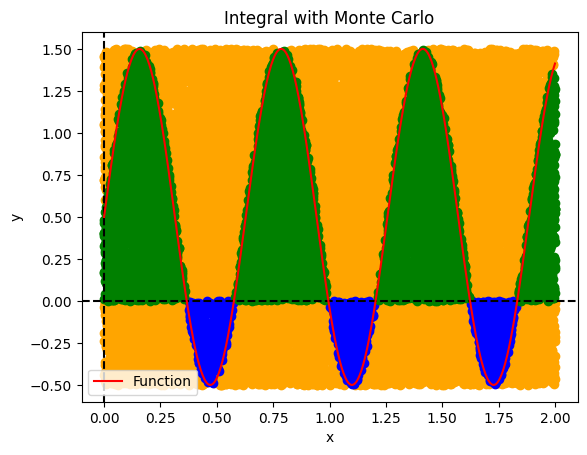


17.157959341s (17157959341ns)


In [16]:
threads = []  # Threads list
points = []  # Random points list generated

# Creates the lock for the threads
lock = Lock()

# Creates the barrier for the threads
barrier = Barrier(num_threads + 1)

# Creates the threads
for i in range(num_threads):
    threads.append(Thread(target=thread_barrier, args=(vals_per_threads, lock, barrier)))

delta_time = time_ns()

# Initialize the threads
for thread in threads:
    thread.start()

# Awaits end of each threads
barrier.wait()

# Plots the graph appling the points
x = sp.Symbol('x')
f = sp.sin(10*x) + 0.5  # Função escolhida
plot_graph_monte_carlo(f, x, points, min_x, max_x)

delta_time = time_ns() - delta_time
print(f"\n{delta_time/1_000_000_000}s ({delta_time}ns)")